## Objective

The objective of the `Tweety` project is to leverage artificial intelligence (AI), specifically a recurrent neural network (RNN) model, to generate text that resembles quotes and tweets, mainly for educational purposes in the field of Natural Language Processing (NLP).

This AI-driven approach allows for the creation of unique and inspiring content, mimicking the style and tone of human-generated quotes and tweets. The project aims to explore the capabilities of RNNs in generating creative and engaging text, which can be used for various purposes such as social media posts, inspirational messages, or even automated content generation for websites and blogs.


Here are a few potential use cases for this model:

- **Content Creation Assistance**: Tweety can assist content creators, bloggers, and social media influencers by generating engaging and relevant quotes or tweet ideas to enhance their content strategy.

- **Social Media Management**: Marketing teams can utilize Tweety to maintain an active presence on social media platforms by automatically generating tweets aligned with their brand identity and marketing objectives.

- **Inspiration and Motivation**: Tweety can provide users with daily doses of inspiration, motivation, or positivity by generating uplifting quotes tailored to individual preferences or moods.

- **Educational Content**: Teachers and educators can use Tweety to generate thought-provoking quotes or discussion prompts to stimulate critical thinking and classroom discussions.

- **Personal Development**: Individuals seeking personal growth and development can receive personalized quotes or affirmations from Tweety to reinforce positive habits or mindset shifts.

- **Product Promotion**: Businesses can leverage Tweety to create attention-grabbing tweets promoting their products or services, enhancing their social media marketing efforts.

- **Event Promotion**: Event organizers can use Tweety to generate catchy and relevant tweets to promote upcoming events, increasing audience engagement and attendance.

- **Real-time Trend Analysis**: Tweety can analyze real-time trends and generate tweets reflecting current events, allowing users to stay updated and participate in relevant online conversations.

- **Customer Engagement**: Brands can engage with their audience on social media by responding to user queries or comments with personalized and contextually relevant tweets generated by Tweety.

- **Influencer Collaboration**: Tweety can collaborate with influencers by providing them with custom-tailored tweets that resonate with their audience, thereby enhancing their online presence and influence.

## Dataset

### Loading the dataset


To train our model, we will utilize a dataset comprising approximately 500,000 quotes sourced from Kaggle.

In [1]:
# download data https://www.kaggle.com/datasets/manann/quotes-500k
!kaggle datasets download -d manann/quotes-500k

Dataset URL: https://www.kaggle.com/datasets/manann/quotes-500k
License(s): unknown
 93% 83.0M/89.6M [00:00<00:00, 88.5MB/s]
100% 89.6M/89.6M [00:01<00:00, 89.4MB/s]


In [2]:
# unzip data into qoutes directory
!unzip -q quotes-500k.zip -d quotes

### Exploring the dataset
The dataset is a .csv file, with the following columns: quote, author, category.
First, we'll look at the first few rows:

In [14]:
import pandas as pd

data_dir = 'quotes'

quotes = pd.read_csv('quotes/quotes.csv')
quotes.head()

,quote,author,category
0,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"attributed-no-source, best, life, love, mistak..."
1,You've gotta dance like there's nobody watchin...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love..."
2,You know you're in love when you can't fall as...,Dr. Seuss,"attributed-no-source, dreams, love, reality, s..."
3,A friend is someone who knows all about you an...,Elbert Hubbard,"friend, friendship, knowledge, love"
4,Darkness cannot drive out darkness: only light...,"Martin Luther King Jr., A Testament of Hope: T...","darkness, drive-out, hate, inspirational, ligh..."


As we can see, the dataset consists of quotes from various authors.
we'll drop category column as we don't need it for this project. Additionally, we will convert author names to lowercase to prevent the duplication of author names in various formats.

In [15]:
quotes = quotes.drop('category', axis=1)
quotes['author'] = quotes['author'].str.lower()

Now let's look at some statistics on the data.

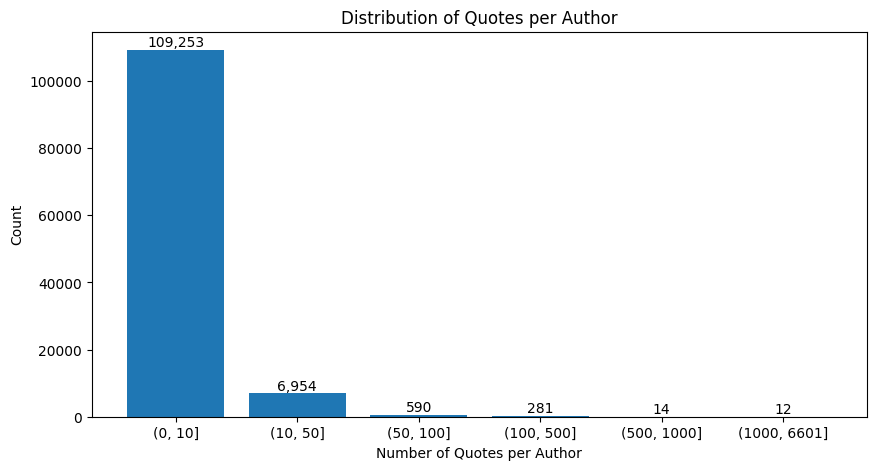

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

quote_per_author = quotes.groupby('author')['quote'].count().sort_values(ascending=False)

# Create bins
bins = [0, 10, 50, 100, 500, 1000, quote_per_author.max()]

# Count the number of quotes in each bin
quote_per_author_bins = pd.cut(quote_per_author, bins=bins, right=True).value_counts()

# Plot the distribution
plt.figure(figsize=(10,5))
plt.bar(quote_per_author_bins.index.astype(str), quote_per_author_bins.values)
plt.xlabel("Number of Quotes per Author")
plt.ylabel("Count")
plt.title("Distribution of Quotes per Author")

# Add data labels to the bars
for i in range(len(quote_per_author_bins)):
  plt.text(i, quote_per_author_bins.values[i]+1000, f"{quote_per_author_bins.values[i]:,.0f}", ha='center')


It seems most of the authors have 1~10 quotes in the dataset, with only 12 authors having more than 1000.

## Preprocessing

To improve the efficiency of our model, we will remove special characters and URLs, and convert all characters to lowercase.

In [19]:
import re

def preprocess_text(text):

  try:
    # Remove special characters

    # Remove special characters
    text = re.sub(r"[^a-zA-Z\s'.]", '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Replace '.!?' with EOS keyword
    text = re.sub(r'[.!?]', ' eos ', text)

    # Convert text to lowercase
    text = text.lower()

  except:
    text = ''

  return text

# Preprocess the quotes
quotes['quote'] = quotes['quote'].apply(preprocess_text).copy()

# Let's take a look at the first few preprocessed quotes:
quotes.head()

,quote,author,word_count
0,i'm selfish impatient and a little insecure eo...,marilyn monroe,44
1,you've gotta dance like there's nobody watchin...,william w. purkey,23
2,you know you're in love when you can't fall as...,dr. seuss,19
3,a friend is someone who knows all about you an...,elbert hubbard,14
4,darkness cannot drive out darkness only light ...,"martin luther king jr., a testament of hope: t...",22


Next, we will examine the distribution of processed quote lengths in terms of the number of words and characters.

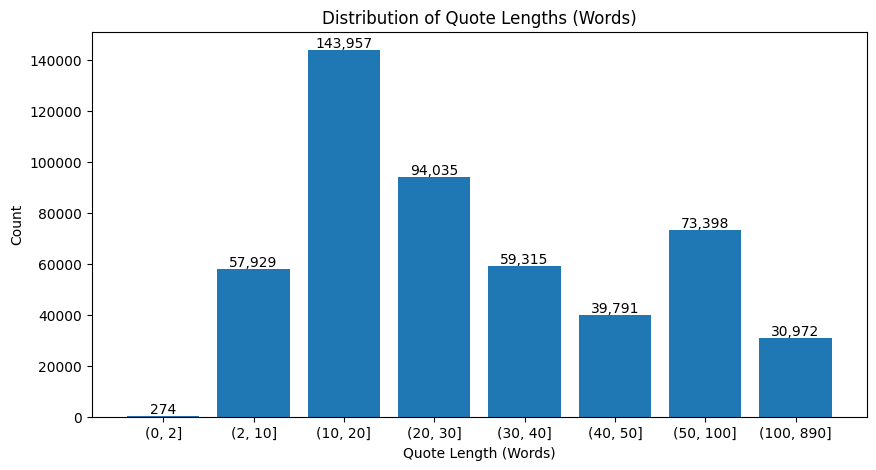

In [20]:

import pandas as pd
import matplotlib.pyplot as plt

quotes['word_count'] = quotes['quote'].apply(lambda x: len(str(x).split()))
bins = [0, 2, 10, 20, 30, 40, 50, 100, quotes['word_count'].max()]

# Count the number of quotes in each bin
quote_length_bins = pd.cut(quotes['word_count'], bins=bins, right=True).value_counts(sort=False)

# Plot the distribution
plt.figure(figsize=(10,5))
plt.bar(quote_length_bins.index.astype(str), quote_length_bins.values)
plt.xlabel("Quote Length (Words)")
plt.ylabel("Count")
plt.title("Distribution of Quote Lengths (Words)")

# Add data labels to the bars
for i in range(len(quote_length_bins)):
  plt.text(i, quote_length_bins.values[i]+1000, f"{quote_length_bins.values[i]:,.0f}", ha='center')

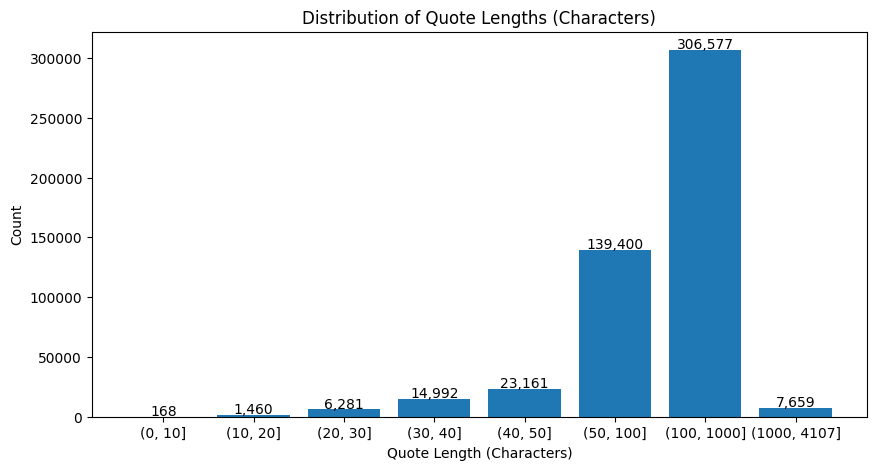

In [21]:
quotes['character_count'] = quotes['quote'].apply(lambda x: len(str(x)))
bins = [0, 10, 20, 30, 40, 50, 100, 1000, quotes['character_count'].max()]

# Count the number of quotes in each bin
quote_length_bins = pd.cut(quotes['character_count'], bins=bins, right=True).value_counts(sort=False)

# Plot the distribution
plt.figure(figsize=(10,5))
plt.bar(quote_length_bins.index.astype(str), quote_length_bins.values)
plt.xlabel("Quote Length (Characters)")
plt.ylabel("Count")
plt.title("Distribution of Quote Lengths (Characters)")

# Add data labels to the bars
for i in range(len(quote_length_bins)):
  plt.text(i, quote_length_bins.values[i]+1000, f"{quote_length_bins.values[i]:,.0f}", ha='center')

### Data cleansing

There are 274 quotes consisting of 1 or 2 words. We will exclude these from the dataset as they do not appear to convey meaningful content.


Furthermore, we aim to prevent our model from being biased towards any single author. Therefore, we will retain a maximum of `max_quote_per_author=1` quotes from each author.

In [22]:
# remove category column and quotes with less than 2 words
quotes = quotes[quotes['word_count'] > 2]

In [23]:
import random
from tqdm import tqdm  # Import tqdm for progress bar

selected_quotes = []
max_quote_per_author = 1  # Define your maximum number of quotes per author

# Group quotes by author and wrap with tqdm for progress bar
for author, group in tqdm(quotes.groupby('author')['quote'], desc='Selecting quotes', total=len(quotes['author'].unique())):
    selected_quotes.extend(random.sample(group.values.tolist(), min(max_quote_per_author, len(group))))

# Shuffle the selected quotes
random.shuffle(selected_quotes)
print(f'selected_quotes: {len(selected_quotes)}')

Selecting quotes: 100%|█████████▉| 116893/116894 [00:03<00:00, 38875.45it/s]

selected_quotes: 116893


We're left with ~117,000 quotes. Let's look at a few samples:



In [24]:
# Print the 5 random quotes
for quote in random.sample(selected_quotes, 10):
  print('- ' + quote)

- take a chance on god eos after all he took a chance on you eos 
-  carlyle labuschagne as i watched her run down the path and melt with the shadows i wasn't sure how to feel about her or the fact that i may just have aided in her escape and doomed us all eos i wanted to believe that anyone given a second chance would use it wisely eos but wisdom i guess is hard to obtain when destiny stands in its way eos 
- nothing is more hip than a corpse eos the style is timeless eos death is trending eos 
- i know ezra that i tend to be a bit impulsive at times but it all seems so reasonable at the time i do these things and so unreasonable when everyone looks back at what happened and what i did
- just because you don't understand it doesn't mean it isn't so
- we all have an edge eos we all are floating our psyche on top with a great ocean underneath eos 
- trauma ruptures and hollows eos compassion mends and fills
- in all small things be honest and the big ones will take care of themselves eo

### Tokenization

Tokenization is the process of breaking text into smaller units called tokens. In the context of this project, tokenization involves splitting quotes into individual words or subwords, which are then used as input for the model. Tokenization helps the model understand the structure of the text and is an essential step in NLP (natural language processing) tasks like text generation.

We use tokenizer from `tensorflow.keras.preprocessing.text` module to tokenize the quotes. The tokenizer processes the text and converts it into a sequence of tokens, which are then encoded as numerical values for the model to understand.

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Define the list of text
texts = selected_quotes

# Create the tokenizer
vocab_size = 2000
eos_token = 'eos'
oov_token = '<OOV>'
tokenizer = Tokenizer(filters='"!?#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n', num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)
encoded_text = tokenizer.texts_to_sequences(texts)

In [1]:
print(f'number of tokens intended (vocab_size): {tokenizer.num_words}')
print(f'number tokens generated by tokenizer: {len(tokenizer.word_index)}')

number of tokens intended (vocab_size): 2000
number tokens generated by tokenizer: 115352


We need to filters the `tokenizer.word_index` dictionary to include only words with an index less than or equal to vocab_size.

In [2]:
tokenizer.word_index = {word: index for word, index in tokenizer.word_index.items() if index <= vocab_size}
print(f'number tokens kept by tokenizer: {2000}')

number tokens kept by tokenizer: 2000


Next, let's examine the most and least frequent tokens retained by our tokenizer in our text corpus.

In [5]:
# most freuqent tokens
print('most freuqent tokens:')
print(dict(list(tokenizer.word_index.items())[:10]))

most freuqent tokens:
{'<OOV>': 1, 'eos': 2, 'the': 3, 'to': 4, 'and': 5, 'of': 6, 'a': 7, 'is': 8, 'i': 9, 'in': 10}


In [4]:
# least freuqent tokens
print('least freuqent tokens:')
print(dict(list(tokenizer.word_index.items())[-10:]))

least freuqent tokens:
{'fat': 1991, 'soldiers': 1992, 'grasp': 1993, 'caring': 1994, 'centuries': 1995, 'deepest': 1996, 'groups': 1997, 'helped': 1998, 'reveal': 1999, 'account': 2000}


Here we'll demonstrate how to encode and decode a sample text using our tokenizer.


First we encode the `sample_text` using `texts_to_sequences` method and then decode it back to the original text using `sequences_to_texts` method. 

In [6]:
sample_text = ['this is a test']
# Encode the text
encoded_sample = tokenizer.texts_to_sequences(sample_text)

# Decode the encoded text
decoded_sample = tokenizer.sequences_to_texts(encoded_sample)

# Print the encoded and decoded text
print(f'Encoded sample: {encoded_sample}')
print(f'Decoded sample: {decoded_sample}')

Encoded sample: [[37, 8, 7, 1517]]
Decoded sample: ['this is a test']


The `convert_sequence_to_feature_target` function is used to prepare data for next word prediction, which is a common task in natural language processing (NLP) and language modeling. Here's an explanation of what the function does and why it's necessary for next word prediction:

- **Input**: The function takes `encoded_text` as input, which is a list of sequences where each sequence represents a tokenized sentence.

- **Output**: It returns two lists, `X` and `y`, where `X` contains sequences of tokens (features) and `y` contains the next token (target) for each corresponding sequence in X.

- **Process**: The function iterates over each sequence in `encoded_text` and generates several feature sequences and their corresponding target sequences. It does this by selecting a window of tokens, starting from the current token and extending back to a maximum sequence length (`max_seq_len`). The next token after the current token is used as the target for each feature sequence.

For example, consider encoded_sentence = [1, 2, 3, 4, 5], and max_seq_len = 3

- For token 1, features = [1] and a target = 2
- For token 2, features = [1, 2] and target = 3
- For token 3, features = [1, 2, 3] and target = 4
- For token 4, features = [2, 3, 4] and target = 5

So, the function's output (X & y) will contain the following elements for this encoded_sentence:

 X = [[1], [1, 2], [1, 2, 3], [2, 3, 4]] and y = [2, 3, 4, 5]

**Why it's necessary**: Next word prediction models, such as those using LSTM or other recurrent neural networks, require input data in the form of sequences of tokens (features) and the next token in each sequence (target). This function prepares the data in this format, making it suitable for training such models.


In [37]:
import numpy as np
def convert_sequence_to_feature_target(encoded_text, min_seq_len = 1, max_seq_len = 16):
    X, y = [], []
    for s in tqdm(encoded_text,  desc='extracting feature & target from sequence'):
        for i in range(min_seq_len, len(s)):
            X.append(s[max(0, i-max_seq_len):i])
            y.append(s[i])

    return X, y

min_seq_len = 1
max_seq_len = 8  # max([len(x) for x in encoded_text])

X, y = convert_sequence_to_feature_target(encoded_text, min_seq_len, max_seq_len)

extracting feature & target from sequence: 100%|██████████| 116893/116893 [00:07<00:00, 16034.54it/s]


### Padding

Padding is a technique commonly used in natural language processing (NLP) to standardize the lengths of sequences in a dataset, such as sentences or lists of words. It involves adding special tokens, often zeros, to sequences that are shorter than a specified length, typically the maximum length in the dataset. This ensures that all sequences have the same length.

Standardizing sequence lengths is crucial for training neural networks effectively. It facilitates batch processing and ensures that the model learns from sequences of uniform length, which is essential for efficient training.

To pad the sequences in `X` to a consistent length (in this case, `max_seq_len=8` for efficiency), we will utilize the `pad_sequences` function from TensorFlow's Keras module. Here is a brief description of this function:

- **Input**: `X` is a list of sequences, where each sequence represents a window of tokens (features) extracted from the input text. `max_seq_len` specifies the maximum length to which each sequence should be padded. `padding='post'` indicates that padding should be added to the end of each sequence.

- **Output**: After padding, `X` will be a numpy array where each row represents a sequence of tokens (features) of the same length. `y` remains a numpy array representing the next token in each sequence.


In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences to have the same length
X = pad_sequences(X, maxlen=max_seq_len, padding='post')
y = np.array(y)

In [39]:
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (4698557, 8)
y.shape: (4698557,)



We use the `train_test_split` function from scikit-learn's model_selection module to split the data (X and y) into training and testing sets. The test_size=0.2 parameter specifies that 20% of the data should be used for testing, and random_state=8 ensures reproducibility by fixing the random seed.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets with an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## RNN Model for next word prediction 

### Glossary
Before building the model, let's clarify some fundamental concepts and components of our model:

- **RNN**: 
Recurrent Neural Networks (RNNs) are a type of neural network designed for sequential data. They process inputs in sequences, maintaining a hidden state that captures information from previous inputs. RNNs are used in tasks like time series prediction and natural language processing, but they can struggle with long sequences due to the vanishing gradient problem.


- **Embedding**:
In NLP, an embedding is a way to represent words as dense vectors in a continuous vector space. These vectors capture semantic relationships between words, with similar words having similar vector representations. Embeddings reduce the dimensionality of word representations, making it easier for neural networks to learn from text data. They are learned from data using techniques like Word2Vec or GloVe and are used as input to NLP models for tasks like sentiment analysis or machine translation. Embeddings generalize well to unseen words and can be fine-tuned for specific tasks. Overall, embeddings are essential for NLP tasks, providing effective representations of words that capture meaning and relationships in text.


- **LSTM**: LSTM (Long Short-Term Memory) is a type of neural network architecture, specifically designed for processing and predicting sequences of data. It addresses the vanishing gradient problem in traditional RNNs, making it more effective for long sequences. LSTMs use a cell state and gates to control the flow of information, allowing them to capture long-term dependencies and remember relevant information over time. They are widely used in tasks like language modeling, speech recognition, and machine translation.

### Model architecture
Here's an explanation of the model architecture:

- **Embedding Layer**: The first layer is the Embedding layer, which is responsible for converting integer indices to dense vectors of fixed size (`embedding_dim`). This layer essentially learns the representation of each word in a continuous vector space.

- **Masking Layer**: The Masking layer is used to handle variable length input sequences. It masks the padded zeros in the input sequences so that they are ignored by the subsequent layers.

- **LSTM Layer**: The Bidirectional LSTM layer is a type of recurrent neural network (RNN) that processes the input sequence in both forward and backward directions. This allows the model to capture long-range dependencies in the input sequences effectively.

- **Output Layer**: The output layer is a Dense layer with a softmax activation function. It produces a probability distribution over the vocabulary (vocab_size) for each time step, indicating the likelihood of each word being the next word in the sequence.

Overall, this is a simple model architecture, suitable for sequence prediction tasks such as next word prediction.


**Compilation**: The model is compiled using the Adam optimizer and sparse categorical crossentropy as the loss function. The sparse categorical crossentropy loss is used because the target variable (`y`) is integer-encoded.

`model.summary()` method prints a summary of the model architecture, including the type of each layer, the output shape of each layer, and the number of trainable parameters.


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Masking, Bidirectional

# Define the LSTM model
embedding_dim = 128
model = Sequential()

# Add masking layer
model.add(Masking(mask_value=0, input_shape=(max_seq_len,)))

# Add embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))

# Add LSTM layer
model.add(Bidirectional(LSTM(units=128)))

# Add output layer
model.add(Dense(units=vocab_size, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 8)                 0         
                                                                 
 embedding_2 (Embedding)     (None, 8, 128)            256000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 2000)              514000    
                                                                 
Total params: 1033168 (3.94 MB)
Trainable params: 1033168 (3.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the model

The model is trained using the `fit` method on the training data, which consists of padded sequences and their corresponding next tokens.

We use a validation split of 0.2, meaning 20% of the training data is used for validation. The `epochs` parameter is set to 3, indicating the number of times the entire dataset is passed through the neural network. A `batch_size` of 64 is used, which means that the model is updated based on 64 samples at a time.

Additionally, an `EarlyStopping` callback is employed to monitor the validation loss (`val_loss`). If the validation loss does not decrease by at least 0.005 for 2 consecutive epochs (`patience=2`), training will stop.

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # restore_best_weights=True

# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/3
46986/46986 [==============================] - 432s 9ms/step - loss: 4.2523 - accuracy: 0.2273 - val_loss: 4.0761 - val_accuracy: 0.2407
Epoch 2/3
46986/46986 [==============================] - 401s 9ms/step - loss: 4.0149 - accuracy: 0.2454 - val_loss: 4.0157 - val_accuracy: 0.2455
Epoch 3/3
46986/46986 [==============================] - 364s 8ms/step - loss: 3.9471 - accuracy: 0.2509 - val_loss: 3.9928 - val_accuracy: 0.2482


#### Storing the model
We'll save the model to Google Drive for future use, as training even this simple model takes a considerable amount of time.

In [46]:
# save the model locally
model.save('tweety')

In [49]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# copy the saved model to google drive
!cp -r tweety /content/drive/MyDrive

### Testing the model

We'll evaluates the trained model on the test set (X_test and y_test) and prints the test loss and accuracy.


Accuracy measures the performance of a next word prediction model by calculating the proportion of correct predictions made by the model out of all predictions made. In the context of next word prediction, accuracy is calculated by comparing the predicted next word to the actual next word in the dataset. If the predicted word matches the actual word, it is considered a correct prediction; otherwise, it is considered incorrect.

For example, if the model predicts the next word in a sequence of text to be "apple" and the actual next word is "apple", this prediction is considered correct. However, if the model predicts "apple" but the actual next word is "orange", this prediction is considered incorrect.

The accuracy is calculated as the number of correct predictions divided by the total number of predictions made by the model. It provides an overall measure of how well the model is able to predict the next word in a sequence of text.

In [51]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

29366/29366 [==============================] - 128s 4ms/step - loss: 3.9943 - accuracy: 0.2475
Test Loss: 3.9942526817321777
Test Accuracy: 0.2475343495607376


### Text generation

Here we'll generate a quote using our trained model (that is capable of predicting the next word given a sequence):

- **Methodology**:
   - **Input**: The method takes a `seed_text` as input, which is used as the starting point for generating the quote.
   - **Output**: The method generates a quote based on the `seed_text` using a trained model for next-word prediction.


- **Parameters**:
   - **seed_text**: The initial text or phrase used to start the generation process.
   - **max_words**: The maximum number of words the generated quote can have. Once this limit is reached, the generation stops.
   - **num_sentences**: The desired number of sentences in the generated quote. The generation stops when this number of sentences is reached.
   - **min_words_per_sentence**: The minimum number of words required for a sentence to be considered complete. If a sentence is shorter than this, the generation continues until a complete sentence is formed.
   - **temperature**: A parameter that controls the randomness of the word selection during generation. Lower values make the generation more deterministic, while higher values make it more random.
   - **top_k**: The number of top words to consider for selection based on their probabilities. Higher values lead to more diverse word selection.
   - **stream**: A boolean flag indicating whether the generated quote should be printed as it is being generated.


- **Generation Process**:
   - The method initializes an empty string to hold the generated quote.
   - It then enters a loop where it predicts the next word in the sequence based on the current quote using the trained model.
   - The predicted word is added to the quote, and the process continues until either the maximum number of words or the desired number of sentences is reached.
   - During each iteration, the word selection is influenced by the `temperature` and `top_k` parameters to control the randomness of the selection.


- **Printing**:
   - If the `stream` parameter is set to `True`, the method prints the generated quote as it is being constructed, providing a real-time view of the generation process.


Overall, this methodology demonstrates how a trained model can be used for creative text generation, such as generating quotes, by predicting the next word in a sequence based on a given input.

In [74]:
import time

# Use the model to generate a quote
def generate_quote(seed_text, max_words=20, num_sentences = 1, min_words_per_sentence = 5, temperature=1., top_k = 5, stream=True):
  """
  This function generates a quote given a seed text and a maximum length.
  """
  # Initialize an empty string to hold the generated quote
  generated_quote = preprocess_text(seed_text)

  if stream:
      print(generated_quote, end = ' ')

  # Loop until the generated quote reaches the maximum length or until a stop word is encountered
  while len(generated_quote.split(' ')) < max_words and generated_quote.count('.') < num_sentences:
    # Convert the seed text to a sequence of integers
    generated_sequence = tokenizer.texts_to_sequences([generated_quote])[0]

    # Pad the sequence
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([generated_sequence], maxlen=max_seq_len, padding='post')

    # Predict the next word probabilities
    probabilities = model.predict(padded_sequence, verbose=False)[0]

    # Calculate probabilities with temperature scaling
    probabilities = np.exp(np.log(probabilities)/temperature)

    # Apply a scaling factor to reduce the probability of highly frequent words

    # Choose the word with the highest probability
    # predicted_word_index = tf.argmax(probabilities).numpy()

    # Choose the top k words based on probabilities
    top_k_indices = np.argpartition(probabilities, -top_k)[-top_k:]
    top_k_probabilities = probabilities[top_k_indices]

    frequent_word_scale = 0.75  # Adjust the scaling factor as needed
    top_k_probabilities_scaled = np.power(top_k_probabilities, frequent_word_scale)

    # Normalize probabilities
    top_k_probabilities = top_k_probabilities / np.sum(top_k_probabilities)

    # Choose a word randomly based on probabilities
    reject_token  = True
    while reject_token:

      reject_token = False
      predicted_word_index = np.random.choice(top_k_indices, p=top_k_probabilities)
      predicted_word = tokenizer.index_word[predicted_word_index]

      if predicted_word == oov_token:
        reject_token = True

      if predicted_word == eos_token and len(generated_quote.split()) < min_words_per_sentence:
        reject_token = True


    # Convert the word index to a word
    if predicted_word == 'eos':
      predicted_word = '.'

    # Append the predicted word to the generated quote
    generated_quote += predicted_word + ' '

    if stream:
      print(predicted_word, end = ' ')
      time.sleep(.1)
  # Return the generated quote
  return generated_quote

# Generate a quote
seed_text = 'wife'
generated_quote = generate_quote(seed_text, max_words=30, num_sentences=1, min_words_per_sentence = 5,
                                 temperature=1., top_k=10, stream=1)



wife and the world of a person who knows it is the key to a question . 